# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## DESAFIO: Algoritmo Genetico Mono-objetivo aplicado al problema de generación de horarios

Los objetivos son:

-	Implementar la representación cromosómica de los cursos
-	Implementar nuevos métodos de mutación para el problema
-   Crear una función de fitness que considere las restricciones obligatorias y opcionales del problema
-   Experimentar con los métodos de cruzamiento y mutación, para obtener aquellas que brinden una solución óptima


### librerias a usar

In [ ]:
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform, choice
from copy import deepcopy
import matplotlib.pyplot as plt
import random

### Define el objeto Curso en el problema de la mochila
Un objeto de clase Item almacena el valor de los IDs del Curso, Profesor Aula y Horario

In [ ]:
class Curso(object):
    def __init__(self, idCurso, idProfesor, idAula, idHorario):
        self.idCurso  = idCurso  #
        self.idProfesor = idProfesor #
        self.idAula = idAula #
        self.idHorario = idHorario #

### Define la función para la creación de cromosomas asignando cada Gen a un Curso

In [ ]:
horarios = [
    {'ID':'H001','Horario':'L-Mi-V 09:00 - 10:00'},
    {'ID':'H002','Horario':'L-Mi-V 10:00 - 11:00'},
    {'ID':'H003','Horario':'Ma-J 09:00 - 10:30'},
    {'ID':'H004','Horario':'Ma-J 10:30 - 12:00'},
]
profesores = [
    {'ID':'P001','Horario_Pref':'','Nombre':'Dr. Edwin Villanueva'},
    {'ID':'P002','Horario_Pref':'H001','Nombre':'Mg. Layla Hirsh'},
    {'ID':'P003','Horario_Pref':'','Nombre':'Dr. Manuel Tupia'},
    {'ID':'P004','Horario_Pref':'H002','Nombre':'Mg. Cesar Aguilera'},
]
aulas = [
    {'ID':'A001','Capacidad':45},
    {'ID':'A002','Capacidad':35},
    {'ID':'A003','Capacidad':25},
]
cursos = [
    {'ID':'C001','Profesores':['P001','P002','P003','P004'],'Cantidad':45,'Curso':'Fundamentos de programación'},
    {'ID':'C002','Profesores':['P004'],'Cantidad':45,'Curso':'Bases de Datos'},
    {'ID':'C003','Profesores':['P002','P003'],'Cantidad':35,'Curso':'Algoritmia'},
    {'ID':'C004','Profesores':['P003','P004'],'Cantidad':30,'Curso':'Sistemas de información'},
    {'ID':'C005','Profesores':['P003','P004'],'Cantidad':30,'Curso':'Sistemas de Información 2'},
    {'ID':'C006','Profesores':['P001','P002'],'Cantidad':25,'Curso':'Machine Learning'},
    {'ID':'C007','Profesores':['P001'],'Cantidad':20,'Curso':'Deep Learning'},
]

In [ ]:
import pandas as pd

df_cursos = pd.DataFrame(cursos)
df_horarios = pd.DataFrame(horarios)
df_aulas = pd.DataFrame(aulas)
df_profesores = pd.DataFrame(profesores)

In [ ]:
def generar_cromosoma(cursos, profesores, aulas, horarios):
    cromosoma = []

    for curso in cursos:
        idCurso = curso['ID']

        # Selecciona un profesor aleatoriamente
        idProfesor = choice(profesores)['ID']

        # Selecciona un aula aleatoriamente
        idAula = choice(aulas)['ID']

        # Selecciona un horario aleatoriamente
        idHorario = choice(horarios)['ID']

        # Agrega la clase al cromosoma, incluso si hay conflictos
        cromosoma.append(Curso(idCurso, idProfesor, idAula, idHorario))

    return cromosoma

In [ ]:
cromosoma = generar_cromosoma(cursos, profesores, aulas, horarios)
for clase in cromosoma:
    print(f"Curso: {clase.idCurso}, Profesor: {clase.idProfesor}, Aula: {clase.idAula}, Horario: {clase.idHorario}")

Curso: C001, Profesor: P004, Aula: A001, Horario: H003
Curso: C002, Profesor: P001, Aula: A001, Horario: H001
Curso: C003, Profesor: P003, Aula: A002, Horario: H003
Curso: C004, Profesor: P004, Aula: A001, Horario: H002
Curso: C005, Profesor: P001, Aula: A002, Horario: H001
Curso: C006, Profesor: P004, Aula: A001, Horario: H003
Curso: C007, Profesor: P002, Aula: A003, Horario: H003


### Define la estructura de un individuo en el AG con sus operadores genéticos

Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes), cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool)

In [ ]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other."
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]

    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other."
        chromosome1 = []
        chromosome2 = []
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(deepcopy(self.chromosome[i]))
                chromosome2.append(deepcopy(other.chromosome[i]))
            else:
                chromosome1.append(deepcopy(other.chromosome[i]))
                chromosome2.append(deepcopy(self.chromosome[i]))
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2]

    def mutation_simple(self):
        "Realiza una mutación en un gen seleccionado aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0, len(new_chromosome))  # escoge un gen para mutar
        curso_mutado = new_chromosome[mutGene]

        # Mutar el horario, profesor o aula
        mutation_type = randrange(0, 3)
        if mutation_type == 0:  # Cambiar horario
            curso_mutado.idHorario = choice(horarios)['ID']
        elif mutation_type == 1:  # Cambiar aula
            curso_mutado.idAula = choice(aulas)['ID']
        elif mutation_type == 2:  # Cambiar profesor
            curso_mutado.idProfesor = choice(profesores)['ID']

        return Individual(new_chromosome)

    def mutation_multi(self):
        "Realiza una mutación en varios genes seleccionados aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGenes = sample(range(0, len(new_chromosome)), randrange(1, len(new_chromosome)))  # escogen varios genes para mutar

        for mutGene in mutGenes:
            curso_mutado = new_chromosome[mutGene]

            # Mutar el horario, profesor o aula
            for i in range(3):
                proba = uniform(0, 1)
                if proba < 0.5:
                    if i == 0:  # Cambiar horario
                        curso_mutado.idHorario = choice(horarios)['ID']
                    elif i == 1:  # Cambiar aula
                        curso_mutado.idAula = choice(aulas)['ID']
                    elif i == 2:  # Cambiar aula
                        curso_mutado.idProfesor = choice(profesores)['ID']

        return Individual(new_chromosome)

### Funcion para inicializar aleatoriamente una población de individuos

In [ ]:
def init_population(pop_size):
    #Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
    population = []
    count = 0
    while count < pop_size:
        try:
            new_chromosome = generar_cromosoma(cursos, profesores, aulas, horarios)
            population.append( Individual(new_chromosome) )
            count += 1
        except Exception as e:
            print(f"Error al generar cromosoma: {e}")
            continue
    return population

## Mono-Objetivo

### Funcion para obtener los fitnesses de un cromosoma

In [ ]:
def get_fitness_mono(chromosome, cursos, horarios, profesores, aulas):
    # Inicializa los contadores para los diferentes aspectos que queremos maximizar
    penalidades = 0
    preferencias = 0
    # Otros factores positivos pueden ser agregados aquí

    # Diccionarios para llevar el control de la disponibilidad de profesores y aulas
    disponibilidad_profesores = {prof['ID']: set(hor['ID'] for hor in horarios) for prof in profesores}
    disponibilidad_aulas = {aula['ID']: set(hor['ID'] for hor in horarios) for aula in aulas}

    for clase in chromosome:
        # print('idHorario:',clase.idHorario,'- idProfesor:', clase.idProfesor,'- idAula:', clase.idAula)
        # print('Disp. profesores',disponibilidad_profesores)
        # Verificar conflictos de horario para profesores y aulas
        if clase.idHorario in disponibilidad_profesores[clase.idProfesor]:
            disponibilidad_profesores[clase.idProfesor].remove(clase.idHorario)
        else:
            # Penalización por conflicto de horario de profesor
            penalidades -= 10

        # print('Disp. aulas',disponibilidad_aulas)
        if clase.idHorario in disponibilidad_aulas[clase.idAula]:
            disponibilidad_aulas[clase.idAula].remove(clase.idHorario)
        else:
            # Penalización por conflicto de horario de aula
            penalidades -= 10

        curso_info = next((curso for curso in cursos if curso['ID'] == clase.idCurso), None)
        aula_info = next((aula for aula in aulas if aula['ID'] == clase.idAula), None)
        if curso_info and aula_info:
            diferencia_capacidad = aula_info['Capacidad'] - curso_info['Cantidad']
            if diferencia_capacidad <= 5 and diferencia_capacidad >= 0:
                preferencias += (10 - diferencia_capacidad)  # Escala de recompensa
            elif diferencia_capacidad < 0:
                penalidades -= 10  # Escala de recompensa
            else:
                penalidades -= 5  # Penalización por diferencia demasiado grande

        if clase.idProfesor not in curso_info['Profesores']:
            penalidades -= 10  # Penalización por profesor no asignado al curso

        if clase.idHorario in ['H003']:
            penalidades -= 5
        elif clase.idHorario in ['H004']:
            penalidades -= 10

        # Verificar si se cumplen las preferencias de los profesores
        for prof in profesores:
            if prof['ID'] == clase.idProfesor and prof.get('Horario_Pref') == clase.idHorario:
                preferencias += 5  # Preferencia cumplida

    # Calcula la aptitud basada en los factores anteriores
    # Puedes ajustar los pesos según la importancia de cada factor
    fitness = preferencias + penalidades
    return fitness

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [ ]:
def select_parents_roulette(population):
    popsize = len(population)

    # Encuentra el valor de fitness más negativo
    min_fitness = min(indiv.fitness for indiv in population)
    offset = 0
    if min_fitness < 0:
        offset = -min_fitness

    # Normaliza los valores de fitness para que todos sean no negativos
    adjusted_fitness = [indiv.fitness + offset if indiv.fitness + offset > 0 else 1 for indiv in population ]

    # Calcula la suma total de fitness normalizada
    sumfitness = sum(adjusted_fitness)  # Suma total del fitness ajustado de la población

    # Escoje el primer padre
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += adjusted_fitness[i]
        if cumfitness > pickfitness:
            iParent1 = i
            break

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - adjusted_fitness[iParent1] # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre
        cumfitness += adjusted_fitness[i]
        if cumfitness > pickfitness:
            iParent2 = i
            break
    try:
        return (population[iParent1], population[iParent2])
    except:
        print(adjusted_fitness)
        print(sumfitness)
        print(pickfitness)
        print(cumfitness)
        return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [ ]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)

    iParent1=np.argmax(list_indiv)

    # Escoje el segundo padre, desconsiderando el primer padre
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)

    return (population[x1[iParent1]],population[x2[iParent2]])

### Funcion para evaluar una población de individuos

In [ ]:
def evaluate_population_mono(population):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness_mono(population[i].chromosome, cursos, horarios, profesores, aulas)

### Operadores de Seleccion de sobrevivientes


#### Función de selección de la poblacion para la sgte generación por ranking
Selecciona la población siguiente ranqueando los individuos de la poblacion actual (population) y la poblacion descendencia (offspring_population) y escogiendo los mejores numsurvivors  individuos

In [ ]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico para encontrar soluciones al problema de la mochila
Recibe una poblacion inicial, lista de items, maximo peso de la mochila (max_weight), numero de generaciones (ngen), taza de mutación (pmut), operador de cruzamiento (crossover), operador de mutacion (mutation), metodo de seleccion de padres (selection_parents_method), metodo de seleccion de sobrevivientes (selection_survivors_method)

In [ ]:
def genetic_algorithm(poblacion_inicial, ngen=100, pmut=0.1,
                      crossover="onepoint", mutation="simple",
                      selection_parents_method="roulette",
                      selection_survivors_method="ranking",
                      top_fitness = 60):
    """Algoritmo Genetico para el problema de la mochila
        items:      pool de items a escoger para la mochila.
                    Debe ser una lista de objetos de clase Item
        max_weight: maximo peso que puede soportar la mochila
        ngen:       maximo numero de generaciones
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes
        top_fitness: fitness objetivo para detener la busqueda
    """

    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial

    popsize = len(population)
    evaluate_population_mono(population)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    best_individuals = [population[ibest[0]]]

    # Algoritmo genetico
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut:
                if mutation == "simple":
                    offspring_population[i] = offspring_population[i].mutation_simple()   # mutacion de una posicion
                elif mutation == "multi":
                    offspring_population[i] = offspring_population[i].mutation_multi()      # mutacion swap
                else:
                    raise NotImplementedError

        ## Evalua la poblacion descendencia creada
        evaluate_population_mono(offspring_population)   # evalua la poblacion descendencia

        ## Selecciona individuos para la sgte. generación
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)

        if population[ibest[0]].fitness >= top_fitness:
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
            best_individuals.append(population[ibest[0]])
            break

        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
            best_individuals.append(population[ibest[0]])

    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness, best_individuals  # devuelve el mejor individuo y la lista de mejores fitness x gen

### Solución

In [ ]:
## Hiperparametros del algoritmo genetico

POP_SIZE = 50
GENERATIONS = 300   # numero de generaciones
PMUT = 0.5         # tasa de mutacion


In [ ]:
poblacion_inicial =  init_population(POP_SIZE)
p = deepcopy(poblacion_inicial)

Poblacion inicial, best_fitness = -35
generacion 0, (Mejor fitness = -35)
generacion 10, (Mejor fitness = 35)
generacion 20, (Mejor fitness = 50)
generacion 25, (Mejor fitness = 60)
Mejor individuo en la ultima generacion = [<__main__.Curso object at 0x7ebc67687fd0>, <__main__.Curso object at 0x7ebc67684880>, <__main__.Curso object at 0x7ebc67674e20>, <__main__.Curso object at 0x7ebc676a8f70>, <__main__.Curso object at 0x7ebc676a8970>, <__main__.Curso object at 0x7ebc676aadd0>, <__main__.Curso object at 0x7ebc676aa710>] (fitness = 60)


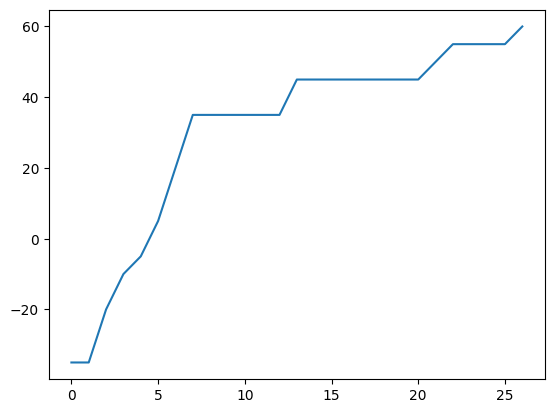

In [ ]:
# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness, _ = genetic_algorithm(p, GENERATIONS, PMUT,
                                          crossover="onepoint", mutation="multi",
                                          selection_parents_method = 'roulette',
                                          selection_survivors_method = 'ranking')

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

In [ ]:
for i in range(len(best_ind.chromosome)):
    idCurso = best_ind.chromosome[i].idCurso
    idProfesor = best_ind.chromosome[i].idProfesor
    idAula = best_ind.chromosome[i].idAula
    idHorario = best_ind.chromosome[i].idHorario
    print(f"Curso: {idCurso}, Profesor: {idProfesor}, Aula: {idAula}, Horario: {idHorario}")

Curso: C001, Profesor: P002, Aula: A001, Horario: H001
Curso: C002, Profesor: P004, Aula: A001, Horario: H002
Curso: C003, Profesor: P003, Aula: A002, Horario: H001
Curso: C004, Profesor: P003, Aula: A002, Horario: H003
Curso: C005, Profesor: P003, Aula: A002, Horario: H002
Curso: C006, Profesor: P002, Aula: A003, Horario: H002
Curso: C007, Profesor: P001, Aula: A003, Horario: H001


In [ ]:
df_resultante = pd.DataFrame(columns=['ID_Curso','Curso', 'Cantidad', 'Profesor', 'Horario', 'Aula', 'Capacidad_Aula'])
for i in range(len(best_ind.chromosome)):
    idCurso = best_ind.chromosome[i].idCurso
    idProfesor = best_ind.chromosome[i].idProfesor
    idAula = best_ind.chromosome[i].idAula
    idHorario = best_ind.chromosome[i].idHorario

    curso_nombre = df_cursos[df_cursos['ID'] == idCurso]['Curso'].values[0]
    curso_cantidad = df_cursos[df_cursos['ID'] == idCurso]['Cantidad'].values[0]
    profesor_nombre = df_profesores[df_profesores['ID'] == idProfesor]['Nombre'].values[0]
    horarios_det = df_horarios[df_horarios['ID'] == idHorario]['Horario'].values[0]
    aula_capacidad = df_aulas[df_aulas['ID'] == idAula]['Capacidad'].values[0]

    df_resultante.loc[i] = [idCurso, curso_nombre, curso_cantidad, profesor_nombre, horarios_det, idAula, aula_capacidad]

In [ ]:
df_resultante

,ID_Curso,Curso,Cantidad,Profesor,Horario,Aula,Capacidad_Aula
0,C001,Fundamentos de programación,45,Mg. Layla Hirsh,L-Mi-V 09:00 - 10:00,A001,45
1,C002,Bases de Datos,45,Mg. Cesar Aguilera,L-Mi-V 10:00 - 11:00,A001,45
2,C003,Algoritmia,35,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A002,35
3,C004,Sistemas de información,30,Dr. Manuel Tupia,Ma-J 09:00 - 10:30,A002,35
4,C005,Sistemas de Información 2,30,Dr. Manuel Tupia,L-Mi-V 10:00 - 11:00,A002,35
5,C006,Machine Learning,25,Mg. Layla Hirsh,L-Mi-V 10:00 - 11:00,A003,25
6,C007,Deep Learning,20,Dr. Edwin Villanueva,L-Mi-V 09:00 - 10:00,A003,25


In [ ]:
profesores

[{'ID': 'P001', 'Horario_Pref': '', 'Nombre': 'Dr. Edwin Villanueva'},
 {'ID': 'P002', 'Horario_Pref': 'H001', 'Nombre': 'Mg. Layla Hirsh'},
 {'ID': 'P003', 'Horario_Pref': '', 'Nombre': 'Dr. Manuel Tupia'},
 {'ID': 'P004', 'Horario_Pref': 'H002', 'Nombre': 'Mg. Cesar Aguilera'}]

In [ ]:
horarios

[{'ID': 'H001', 'Horario': 'L-Mi-V 09:00 - 10:00'},
 {'ID': 'H002', 'Horario': 'L-Mi-V 10:00 - 11:00'},
 {'ID': 'H003', 'Horario': 'Ma-J 09:00 - 10:30'},
 {'ID': 'H004', 'Horario': 'Ma-J 10:30 - 12:00'}]

## Experimentos

### Solo Cruzamiento

In [ ]:
## Hiperparametros del algoritmo genetico

POP_SIZE = 50
GENERATIONS = 300   # numero de generaciones
PMUT = 0.0         # tasa de mutacion

poblacion_inicial =  init_population(POP_SIZE)
p = deepcopy(poblacion_inicial)

In [ ]:
metodoSeleccion=['roulette','tournament']
crossover=['onepoint', 'uniform']
mutation=['simple','multi']

In [ ]:
bestfitnesses = []
bestfitness_generation = []
bestfitness_prom = {}
bestfitness_generation_prom = {}

for current_metodoSeleccion in metodoSeleccion:
    for current_crossover in crossover:
        print(f"Método Selección:{current_metodoSeleccion} - Cruzamiento: {current_crossover}")
        for i in range(10):
            print(f"Iteración: {i+1}")
            best_ind, bestfitness, _ = genetic_algorithm(p, GENERATIONS, PMUT,
                                                      crossover=current_crossover, mutation="multi",
                                                      selection_parents_method = current_metodoSeleccion,
                                                      selection_survivors_method = 'ranking')

            bestfitnesses.append(max(bestfitness))  # guarda el mejor fitness de cada iteracion
            bestfitness_generation.append(bestfitness.index(max(bestfitness)))  # guarda la generacion donde se obtiene el mejor fitness de cada iteracion

        # Calcula la media de los mejores fitness de cada iteración
        bestfitness_prom[(current_metodoSeleccion, current_crossover)] = np.mean(bestfitnesses, axis = 0)
        bestfitness_generation_prom[(current_metodoSeleccion, current_crossover)] = np.mean(bestfitness_generation)
        print('-'*200)

        # Reinicia las listas para la siguiente iteración
        bestfitnesses = []
        bestfitness_generation = []

Método Selección:roulette - Cruzamiento: onepoint
Iteración: 1
Poblacion inicial, best_fitness = -35
generacion 0, (Mejor fitness = -30)
generacion 10, (Mejor fitness = 35)
generacion 20, (Mejor fitness = 35)
generacion 30, (Mejor fitness = 35)
generacion 40, (Mejor fitness = 35)
generacion 50, (Mejor fitness = 35)
generacion 60, (Mejor fitness = 35)
generacion 70, (Mejor fitness = 35)
generacion 80, (Mejor fitness = 35)
generacion 90, (Mejor fitness = 35)
generacion 100, (Mejor fitness = 35)
generacion 110, (Mejor fitness = 35)
generacion 120, (Mejor fitness = 35)
generacion 130, (Mejor fitness = 35)
generacion 140, (Mejor fitness = 35)
generacion 150, (Mejor fitness = 35)
generacion 160, (Mejor fitness = 35)
generacion 170, (Mejor fitness = 35)
generacion 180, (Mejor fitness = 35)
generacion 190, (Mejor fitness = 35)
generacion 200, (Mejor fitness = 35)
generacion 210, (Mejor fitness = 35)
generacion 220, (Mejor fitness = 35)
generacion 230, (Mejor fitness = 35)
generacion 240, (Mejo

In [ ]:
bestfitness_prom

{('roulette', 'onepoint'): 18.0,
 ('roulette', 'uniform'): 25.0,
 ('tournament', 'onepoint'): 11.0,
 ('tournament', 'uniform'): 24.0}

In [ ]:
bestfitness_generation_prom

{('roulette', 'onepoint'): 7.0,
 ('roulette', 'uniform'): 8.4,
 ('tournament', 'onepoint'): 6.7,
 ('tournament', 'uniform'): 11.4}

### Cruzamiento y Mutación

In [ ]:
## Hiperparametros del algoritmo genetico

POP_SIZE = 50
GENERATIONS = 300   # numero de generaciones
PMUT = [0.1, 0.5, 0.8, 1.0]         # tasa de mutacion

poblacion_inicial =  init_population(POP_SIZE)
p = deepcopy(poblacion_inicial)

In [ ]:
bestfitnesses = []
bestfitness_generation = []
bestfitness_prom = {}
bestfitness_generation_prom = {}

for current_mutation in mutation:
    for current_PMUT in PMUT:
        print(f"Mutación:{current_mutation} - Tasa de Mutación: {current_PMUT}")
        for i in range(10):
            print(f"Iteración: {i+1}")
            best_ind, bestfitness, _ = genetic_algorithm(p, GENERATIONS, current_PMUT,
                                                      crossover='uniform', mutation=current_mutation,
                                                      selection_parents_method = 'roulette',
                                                      selection_survivors_method = 'ranking')

            bestfitnesses.append(max(bestfitness))  # guarda el mejor fitness de cada iteracion
            bestfitness_generation.append(bestfitness.index(max(bestfitness)))  # guarda la generacion donde se obtiene el mejor fitness de cada iteracion

        # Calcula la media de los mejores fitness de cada iteración
        bestfitness_prom[(current_mutation, current_PMUT)] = np.mean(bestfitnesses, axis = 0)
        bestfitness_generation_prom[(current_mutation, current_PMUT)] = np.mean(bestfitness_generation)
        print('-'*200)

        # Reinicia las listas para la siguiente iteración
        bestfitnesses = []
        bestfitness_generation = []

Mutación:simple - Tasa de Mutación: 0.1
Iteración: 1
Poblacion inicial, best_fitness = -40
generacion 0, (Mejor fitness = -40)
generacion 10, (Mejor fitness = 40)
generacion 20, (Mejor fitness = 50)
generacion 30, (Mejor fitness = 50)
generacion 40, (Mejor fitness = 50)
generacion 43, (Mejor fitness = 60)
Mejor individuo en la ultima generacion = [<__main__.Curso object at 0x7ebc6763e020>, <__main__.Curso object at 0x7ebc6763c850>, <__main__.Curso object at 0x7ebc6763e650>, <__main__.Curso object at 0x7ebc6763c6d0>, <__main__.Curso object at 0x7ebc6763c760>, <__main__.Curso object at 0x7ebc6763ffd0>, <__main__.Curso object at 0x7ebc6763f940>] (fitness = 60)
Iteración: 2
Poblacion inicial, best_fitness = -40
generacion 0, (Mejor fitness = -35)
generacion 10, (Mejor fitness = 25)
generacion 20, (Mejor fitness = 35)
generacion 30, (Mejor fitness = 45)
generacion 40, (Mejor fitness = 50)
generacion 50, (Mejor fitness = 50)
generacion 60, (Mejor fitness = 50)
generacion 70, (Mejor fitness =

In [ ]:
bestfitness_prom

{('simple', 0.1): 58.0,
 ('simple', 0.5): 60.0,
 ('simple', 0.8): 59.5,
 ('simple', 1.0): 60.0,
 ('multi', 0.1): 59.5,
 ('multi', 0.5): 60.0,
 ('multi', 0.8): 60.0,
 ('multi', 1.0): 60.0}

In [ ]:
bestfitness_generation_prom

{('simple', 0.1): 36.1,
 ('simple', 0.5): 20.7,
 ('simple', 0.8): 18.8,
 ('simple', 1.0): 19.0,
 ('multi', 0.1): 95.9,
 ('multi', 0.5): 57.7,
 ('multi', 0.8): 23.4,
 ('multi', 1.0): 40.8}

### Mejor algoritmo

In [36]:
## Hiperparametros del algoritmo genetico

POP_SIZE = 50
GENERATIONS = 300   # numero de generaciones
PMUT = 0.5          # tasa de mutacion

poblacion_inicial =  init_population(POP_SIZE)
p = deepcopy(poblacion_inicial)

Poblacion inicial, best_fitness = -15
generacion 0, (Mejor fitness = -15)
generacion 10, (Mejor fitness = 50)
generacion 14, (Mejor fitness = 60)
Mejor individuo en la ultima generacion = [<__main__.Curso object at 0x7ebc676a2ef0>, <__main__.Curso object at 0x7ebc676a3ac0>, <__main__.Curso object at 0x7ebc676a0d60>, <__main__.Curso object at 0x7ebc676a3fa0>, <__main__.Curso object at 0x7ebc676a2620>, <__main__.Curso object at 0x7ebc676a2a70>, <__main__.Curso object at 0x7ebc676a26e0>] (fitness = 60)


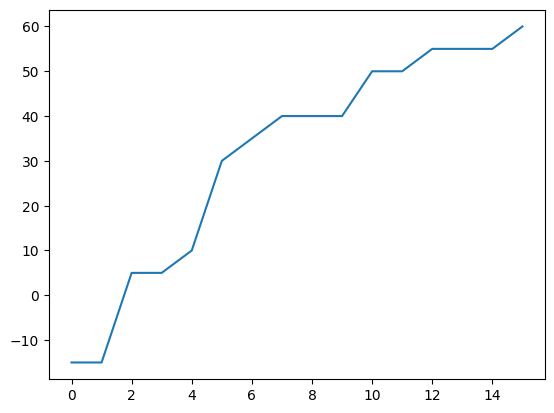

In [37]:
# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness, best_individuals = genetic_algorithm(p, GENERATIONS, PMUT,
                                          crossover="uniform", mutation="simple",
                                          selection_parents_method = 'roulette',
                                          selection_survivors_method = 'ranking')

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

In [38]:
cronogramas = []
cronogramas_fitness = []
for individual in best_individuals:
    print('Fitness:', individual.fitness)
    cronogramas_fitness.append(individual.fitness)
    df_resultante = pd.DataFrame(columns=['ID_Curso','Curso', 'Cantidad', 'Profesor', 'Horario', 'Aula', 'Capacidad_Aula'])
    for i in range(len(individual.chromosome)):
        idCurso = individual.chromosome[i].idCurso
        idProfesor = individual.chromosome[i].idProfesor
        idAula = individual.chromosome[i].idAula
        idHorario = individual.chromosome[i].idHorario
        print(f"Curso: {idCurso}, Profesor: {idProfesor}, Aula: {idAula}, Horario: {idHorario}")

        curso_nombre = df_cursos[df_cursos['ID'] == idCurso]['Curso'].values[0]
        curso_cantidad = df_cursos[df_cursos['ID'] == idCurso]['Cantidad'].values[0]
        profesor_nombre = df_profesores[df_profesores['ID'] == idProfesor]['Nombre'].values[0]
        horarios_det = df_horarios[df_horarios['ID'] == idHorario]['Horario'].values[0]
        aula_capacidad = df_aulas[df_aulas['ID'] == idAula]['Capacidad'].values[0]

        df_resultante.loc[i] = [idCurso, curso_nombre, curso_cantidad, profesor_nombre, horarios_det, idAula, aula_capacidad]
    cronogramas.append(df_resultante)
    print('-'*200)

Fitness: -15
Curso: C001, Profesor: P003, Aula: A001, Horario: H001
Curso: C002, Profesor: P003, Aula: A001, Horario: H002
Curso: C003, Profesor: P002, Aula: A002, Horario: H002
Curso: C004, Profesor: P003, Aula: A002, Horario: H004
Curso: C005, Profesor: P003, Aula: A003, Horario: H003
Curso: C006, Profesor: P001, Aula: A003, Horario: H002
Curso: C007, Profesor: P003, Aula: A002, Horario: H001
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fitness: -15
Curso: C001, Profesor: P003, Aula: A001, Horario: H001
Curso: C002, Profesor: P003, Aula: A001, Horario: H002
Curso: C003, Profesor: P002, Aula: A002, Horario: H002
Curso: C004, Profesor: P003, Aula: A002, Horario: H004
Curso: C005, Profesor: P003, Aula: A003, Horario: H003
Curso: C006, Profesor: P001, Aula: A003, Horario: H002
Curso: C007, Profesor: P003, Aula: A002, Horario: H001
---

In [39]:
for cronograma, fitness in zip(cronogramas,cronogramas_fitness):
    print(f"Fitness: {fitness}")
    display(cronograma)
    print('-'*200)

Fitness: -15


,ID_Curso,Curso,Cantidad,Profesor,Horario,Aula,Capacidad_Aula
0,C001,Fundamentos de programación,45,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A001,45
1,C002,Bases de Datos,45,Dr. Manuel Tupia,L-Mi-V 10:00 - 11:00,A001,45
2,C003,Algoritmia,35,Mg. Layla Hirsh,L-Mi-V 10:00 - 11:00,A002,35
3,C004,Sistemas de información,30,Dr. Manuel Tupia,Ma-J 10:30 - 12:00,A002,35
4,C005,Sistemas de Información 2,30,Dr. Manuel Tupia,Ma-J 09:00 - 10:30,A003,25
5,C006,Machine Learning,25,Dr. Edwin Villanueva,L-Mi-V 10:00 - 11:00,A003,25
6,C007,Deep Learning,20,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A002,35


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fitness: -15


,ID_Curso,Curso,Cantidad,Profesor,Horario,Aula,Capacidad_Aula
0,C001,Fundamentos de programación,45,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A001,45
1,C002,Bases de Datos,45,Dr. Manuel Tupia,L-Mi-V 10:00 - 11:00,A001,45
2,C003,Algoritmia,35,Mg. Layla Hirsh,L-Mi-V 10:00 - 11:00,A002,35
3,C004,Sistemas de información,30,Dr. Manuel Tupia,Ma-J 10:30 - 12:00,A002,35
4,C005,Sistemas de Información 2,30,Dr. Manuel Tupia,Ma-J 09:00 - 10:30,A003,25
5,C006,Machine Learning,25,Dr. Edwin Villanueva,L-Mi-V 10:00 - 11:00,A003,25
6,C007,Deep Learning,20,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A002,35


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fitness: 50


,ID_Curso,Curso,Cantidad,Profesor,Horario,Aula,Capacidad_Aula
0,C001,Fundamentos de programación,45,Dr. Manuel Tupia,L-Mi-V 09:00 - 10:00,A001,45
1,C002,Bases de Datos,45,Mg. Cesar Aguilera,L-Mi-V 10:00 - 11:00,A001,45
2,C003,Algoritmia,35,Mg. Layla Hirsh,L-Mi-V 09:00 - 10:00,A002,35
3,C004,Sistemas de información,30,Dr. Manuel Tupia,Ma-J 10:30 - 12:00,A002,35
4,C005,Sistemas de Información 2,30,Mg. Cesar Aguilera,L-Mi-V 10:00 - 11:00,A002,35
5,C006,Machine Learning,25,Dr. Edwin Villanueva,L-Mi-V 10:00 - 11:00,A003,25
6,C007,Deep Learning,20,Dr. Edwin Villanueva,L-Mi-V 09:00 - 10:00,A003,25


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fitness: 60


,ID_Curso,Curso,Cantidad,Profesor,Horario,Aula,Capacidad_Aula
0,C001,Fundamentos de programación,45,Mg. Cesar Aguilera,L-Mi-V 09:00 - 10:00,A001,45
1,C002,Bases de Datos,45,Mg. Cesar Aguilera,L-Mi-V 10:00 - 11:00,A001,45
2,C003,Algoritmia,35,Mg. Layla Hirsh,L-Mi-V 09:00 - 10:00,A002,35
3,C004,Sistemas de información,30,Dr. Manuel Tupia,Ma-J 09:00 - 10:30,A002,35
4,C005,Sistemas de Información 2,30,Dr. Manuel Tupia,L-Mi-V 10:00 - 11:00,A002,35
5,C006,Machine Learning,25,Dr. Edwin Villanueva,L-Mi-V 10:00 - 11:00,A003,25
6,C007,Deep Learning,20,Dr. Edwin Villanueva,L-Mi-V 09:00 - 10:00,A003,25


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
